In [1]:
from sklearn.datasets import load_iris
from typing import *

import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# some dataset we want to train on
# since this is a minimal example we do not care about test train splits
x, y = load_iris(return_X_y=True)
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).long()

# Some blackbox function
The info calculated in the function may come frome anywhere.

In [3]:
def have_all_weights_around_abs_5(net_params: torch.Tensor):
    ''' An arbitrary quality function `L_{bb} `
    asking the network weights to be distributed closely around -5 and 5.
    The function does not provide a gradient.
    '''
    with torch.no_grad(): # ensure no gradient (again!)
        return torch.linalg.norm(net_params.abs() - 5)

## Estimating gradients through a blackbox

Given a neural network with parameters $\theta$, a network should be trained given a (white-box) loss function $L_{wb}(\theta)$ (e.g., Cross entropy). 

Additionally, some black-box loss function $L_{bb}(\theta)$ expresses additional preferences about the solution or training result .

A classical training objective would be
$$ \min_\theta \; L = L_{wb}(\theta) + \lambda L_{bb}(\theta), \quad \lambda \in \mathcal{R}^+$$ 
Unfortunately, since $L_{bb}(\theta) $ is a $\textbf{black-box}$, we cannot optimize this objective with gradient-based methods.

However, if we assume $\theta \sim p(\theta; \mu) = \mathcal{N}(\mu, \sigma^2\cdot I) $ with $\sigma$ fixed (hyperparameter) and change the training objective to 
$$\min_\mu  L(\mu) + \lambda \int  L_{bb}(\theta) p(\theta; \mu) \; \rm d \theta, $$
we can estimate gradients via the score function estimate (under some assumptions) by

\begin{align}
& \nabla_\mu L_{wb}(\mu) + \lambda \nabla_\mu \int L_{bb}(\theta) \;  p(\theta; \mu) \; \rm d \theta \\
=&  \nabla_\mu L_{wb}(\mu) + \lambda \int L_{bb}(\theta) \; \nabla_\mu p(\theta; \mu) \; \rm d \theta  &\text{assumption (unbounded support of p($\theta$),} \dots) \\
=& \nabla_\mu L_{wb}(\mu) + \lambda \int L_{bb}(\theta) \; \nabla_\mu \ln p(\theta; \mu) \; p(\theta; \mu) \; \rm d \theta \quad &\text{score function estimate (reinforce)} \\
\approx& \nabla_\mu L_{wb}(\mu) + \frac{\lambda}{n} \sum_n  L_{bb}( \theta^{(n)}) \; \nabla_\mu \ln p( \theta^{(n)}; \mu) \quad \text{with} \quad  \theta^{(n)} \sim p( \theta; \mu) \\
\end{align}

In [4]:
from gradient_estimation import BlackboxGradientEstimator

# This will estimate the gradient for L_bb
grad_estimator = BlackboxGradientEstimator(
    black_box_function=have_all_weights_around_abs_5
)

def train_net(net_, bb_grad_estimation_args, epochs=10, lr=1e-3):
    ''' 
    A network training function including gradient estimation
    for the blackbox loss function.
    '''
    
    opt = torch.optim.Adam(net_.parameters(), lr=lr)
    L_wb = torch.nn.CrossEntropyLoss()
    
    # just for tracking
    L_wb_s = []
    L_bb_s = []
    
    
    for _ in range(epochs):
        opt.zero_grad()
        
        # basic dl_wb/dparams
        diff_loss = L_wb(net_(x), y)
        diff_loss.backward()
        
        # estimate gradient of blackbox
        grad_estimator.add_estimated_grad_to_network(
            network=net_, **bb_grad_estimation_args
        )
        
        # just for tracking progress
        L_wb_s.append(diff_loss.item())
        current_params = torch.cat([p.flatten() for p in net_.parameters()])
        L_bb_s.append(
            grad_estimator.black_box_function(current_params).item())
            
        opt.step()
        
    return net_, L_wb_s, L_bb_s

In [5]:
torch.manual_seed(1)

# some arbitrary NN
n_neurons = 10
net = torch.nn.Sequential(
    torch.nn.Linear(4,n_neurons), torch.nn.SiLU(),
    torch.nn.Linear(n_neurons, n_neurons), torch.nn.SiLU(),
    torch.nn.Linear(n_neurons, 3)
)

# Arguments for the gradient estimation
bb_grad_estimation_args = {
    'num_samples' : 100,
    'sigma' : 1.,
    'bb_objective_coef' : 1, 
    'clip_norm' : 1.
}

# train network
mynet, losses, obj_values = train_net(
    net, bb_grad_estimation_args, epochs=1000, lr=1e-1)

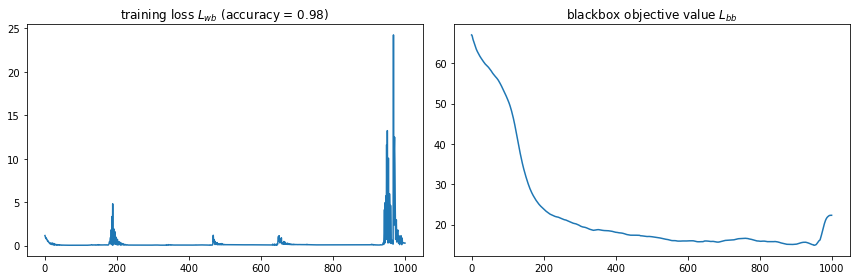

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
accuracy = round((net(x).argmax(1) == y).float().mean().item(),4)
ax[0].plot(losses)
ax[0].set_title('training loss $L_{wb}$ '+  f'(accuracy = {accuracy})')
ax[1].plot(obj_values)
ax[1].set_title('blackbox objective value $L_{bb}$')
plt.tight_layout();

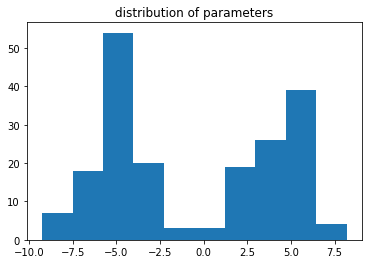

In [7]:
# As we can see, we reach a reasonable performance for 
# the black box Loss function L_{bb}.
plt.hist(torch.cat([p.flatten() for p in net.parameters()]).detach().numpy())
plt.title('distribution of parameters'); 